$\dot{\vec p} = \frac{1}{2\beta}[\vec{k} - (\vec k \cdot \vec p)\vec p] + \frac 1 2 \vec \omega \times \vec p$

$\beta = \mu \alpha /2\rho g h$

$\vec \omega = \nabla \times \vec v_{flow}$

$v_{flow} = Ar + \frac B r \implies \vec \omega = (0, 0, 2A)$ 

$A = \cfrac{-\Omega}{R_2^2/R_1^2-1} \space B = \cfrac{\Omega R_2^2}{R_2^2/R_1^2-1}$

$\dot{\vec R} =  v_0 \vec p + \vec v_{flow}$

Cut-off Lennard-Jones potential

$$ V_W = 
\begin{cases}
    4\varepsilon \left[ (\frac{\sigma_W}{r}) ^{12} - (\frac{\sigma_W}{r}) ^{6}\right] +\varepsilon, \ \text{for} \ r<d^*\\
      0
    \end{cases} $$
$$d^* = 2^{1/6}  \sigma_W =R  \quad \sigma_W = R/2^{1/6}$$
$$ F_W = -\cfrac{\partial V_W}{\partial r}$$


$$\dot{\vec p} = \frac{1}{2\beta}[\vec{k} - (\vec k \cdot \vec p)\vec p] + \frac 1 2 \vec \omega \times \vec p - 2D_Rdt\vec p+ (\vec\eta_R \times \vec p)\sqrt{2D_Rdt}$$
$$\beta = \mu \alpha /2\rho g h,  \vec \omega = \nabla \times \vec v_{flow}, \vec v_{flow} = (-Ay, Ax, 0)$$ 

$$\dot{\vec R} =  v_0 \vec p  + \vec v_{flow} + \mu\vec F_W + \vec\eta_T\sqrt{2D_Tdt} $$

$\gamma = 6\pi\eta R \quad \mu = 1/\gamma$

In [108]:
import numpy as np
from scipy.integrate import odeint
#from scipy.spatial import KDTree
from numba_kdtree import KDTree
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from numba import njit
from scipy.integrate import quad

### Export

In [3]:
def save_output(time, Rs_sol, ps_sol, N, Omega):
    f = open(f"outputOmega{Omega}N{N}.txt", "w")
    for i in range(0, 50000, 10):
        f.write("ITEM: TIMESTEP"+ '\n')
        f.write(str(time[i])+ '\n')
        f.write("ITEM: NUMBER OF ATOMS"+ '\n')
        f.write(str(N)+ '\n')
        f.write("ITEM: ATOMS id x y z vx vy vz"+ '\n')
        for j in range(N):
            s = ''
            s += str(j)
            for k in range(3):
                s += ' '
                s += str(Rs_sol[i, j, k])
            #s += ' 0'
            for k in range(3):
                s += ' '
                s += str(ps_sol[i, j, k])
            f.write(s+ '\n')
    f.close()        
    

### Plotting

In [4]:
def data_for_cylinder_along_z(radius, height_z, null_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2 * np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z + null_z)
    x_grid = radius * np.cos(theta_grid)
    y_grid = radius * np.sin(theta_grid)
    return x_grid, y_grid, z_grid



def makesphere(x, y, z, radius, resolution=10):
    """Return the coordinates for plotting a sphere centered at (x,y,z)"""
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

In [5]:
def plot_state(coords):
    ax = plt.figure().add_subplot(projection='3d')

    for i in range(len(coords)):
        X, Y, Z = makesphere(coords[i][0], coords[i][1], coords[i][2], R)
        ax.plot_surface(X, Y, Z, color="r")

    X1,Y1,Z1 = data_for_cylinder_along_z(R1, L, 0)
    ax.plot_surface(X1, Y1, Z1, alpha=0.5)

    X2,Y2,Z2 = data_for_cylinder_along_z(R2, L, 0)
    ax.plot_surface(X2, Y2, Z2, alpha=0.5)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.axis('equal');

    plt.show()

In [6]:
def plot_dist(sol, threshold, bins):
    dist = distance_matrix(sol[-1, :, :],sol[-1,:,:])
    ds = dist[np.triu_indices(N, k = 1)]
    ds_short = [d for d in ds if d < threshold]

    fig, axs = plt.subplots(1, 2, figsize = (12,5))
    axs[0].hist(ds, bins = bins,  density=False);
    axs[1].hist(ds_short, bins = bins,  density=False);

    axs[0].set_xlabel('distance between particles')
    axs[1].set_xlabel('distance between particles')

    plt.show()

In [7]:
def plot_angle(A, sol, bins):
    psi = np.arctan2(sol[-1, :, 1], sol[-1, :, 0]) * 180 / np.pi
    if -1 < (2 * A * beta) and (2 * A * beta) < 1:
        phi_star = np.arcsin(2 * A * beta) * 180 / np.pi
        plt.axvline(phi_star, color = 'r')

    plt.hist(psi,  bins = bins, density=False);
    plt.xlabel(f'psi')
    plt.ylabel(f'# particles')
    plt.show()


In [8]:
def plot_2d(coords):
    fig, axs = plt.subplots(figsize = (10,10))
    inner = plt.Circle((0, 0), R1, color='b', fill=False)
    outer = plt.Circle((0, 0), R2, color='b', fill=False)
    axs.add_patch(inner)
    axs.add_patch(outer)

    ind=np.argsort(coords[:,-1])
    b=coords[ind]

    for i in range(N):
        plt.scatter(b[i][0], b[i][1], s = 300 * (1 - b[i][2]/L), c = b[i][2], cmap = 'jet', vmin = 0, vmax = L)
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.grid(True)
    axs.axis('equal')
    plt.colorbar()
    plt.show()    

In [9]:
def plot_R_mean(sol):
    Rads = np.mean(np.linalg.norm(sol[:, :, :2], axis = 2), axis = 1)

    fig, axs = plt.subplots()
    axs.plot(t, Rads)
    axs.set_xlabel('Time')
    axs.set_ylabel('Mean radial coordinate')
    axs.grid(True)

    plt.show()


In [10]:
def plot_trajectory(sol_i):
    fig, axs = plt.subplots()
    axs.plot(sol_i[:,0], sol_i[:,1])
    axs.plot(sol_i[0,0], sol_i[0,1], 'o')

    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.grid(True)
   
    axs.axis('equal')
    plt.show()   

### Model

In [187]:
# constants

R = 1 # swimmer radius
v0 = 1 # swimmer speed
eta = 1 # viscosity
R1 = 5 * R # inner radius
R2 = 50 * R # outer radius
L = 200 * R # length
#Omega = 0.1 # inner rotation speed 
#Omega = 5 # inner rotation speed 

beta = 200

mu = 1 / (6 * np.pi * eta * R)
print(mu)

#alpha = 0.0331355721
alpha = 0.001656

D_T  = alpha / (6 * np.pi)
D_R = alpha / (8 * np.pi)

k = np.array([1, 0, 0]) # up vector

sigma0 = 0.1 # variance 

print(f'1/D_R*beta: {1 / D_R / beta}')

sigma_wall = 2 ** (- 1 / 6) * R
sigma_part = 2 ** (- 1 / 6) * 2 * R

Omega_crit = ((R2 / R1) ** 2 - 1) / 2 / beta
print('Omega_crit:', Omega_crit)

0.05305164769729845
1/D_R*beta: 75.88388052149259
Omega_crit: 0.2475


In [12]:
def get_params(Omega):
    A = - Omega / (R2 ** 2 / R1 ** 2 - 1)
    B = Omega * R2 ** 2 / (R2 ** 2 / R1 ** 2 - 1)

    Omega_crit = ((R2 / R1) ** 2 - 1) / 2 / beta

    #print(Omega_crit)

    if Omega > Omega_crit:
        T_tumb = 4 * np.pi * beta / np.sqrt(4 * A **2 * beta ** 2 - 1)
        print(f'Tumbling period: {T_tumb}')
    else:
        print('No tumbling')
        
    omega = np.array([0, 0, 2 * A]) # flow curl
    print(f'omega/D_R: {- 2 * A / D_R}')
    
    return A, B, omega

In [13]:
def get_v_flow(A, B, poses):
    R_norm = np.linalg.norm(poses, axis = 1)
    v = A * R_norm + B / R_norm
    vs = np.array([- v * poses[:,1] / R_norm, v * poses[:,0] / R_norm]).T
    return np.hstack((vs, np.zeros((1, v.shape[0])).T))

In [14]:
poses = np.array([[1, 0, 0], [1, 1, 0]], dtype = np.float64)
get_v_flow(1,0,poses)

array([[-0.,  1.,  0.],
       [-1.,  1.,  0.]])

In [15]:
@njit
def force(r, epsilon, sigma, delta=1e-6):
    return 24 * epsilon * (2 * sigma ** 12 / (r + delta) ** 13 - sigma ** 6 / (r + delta) ** 7)

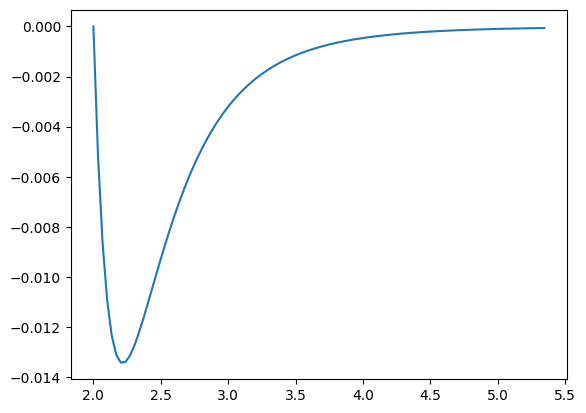

In [201]:
rs = np.linspace(2, 3 * sigma_part, 100)
plt.plot(rs, force(rs, 0.01, sigma_part))


In [17]:
def get_wall_force(poses):
    R_norm = np.linalg.norm(poses, axis = 1)
    epsilon = 0.01
    f = np.empty_like(R_norm)
    for i in range(f.shape[0]):
        if (R_norm[i] < R1 + R):
            if (R_norm[i] < R1 + 0.59):
                f[i] = 1e2
            else:
                f[i] = force(R_norm[i] - R1, epsilon, sigma_wall)          
        elif (R_norm[i] > R2 - R):
            if (R_norm[i] > R2 - 0.59):
                f[i] = - 1e2
            else:
                f[i] = - force(R2 - R_norm[i], epsilon, sigma_wall)
        else:
            f[i] = 0
    fs = np.array([f * poses[:,0] / R_norm, f * poses[:,1] / R_norm]).T
    return np.hstack((fs, np.zeros((1, f.shape[0])).T))

In [18]:
def get_interaction_force(pos1, poses):
    R_norm = np.linalg.norm(poses - pos1, axis = 1)
    epsilon = 0.01
    f = np.empty_like(R_norm)
    for i in range(f.shape[0]):
        if R_norm[i] > 1.113:
            f[i] = force(R_norm[i], epsilon, sigma_part)
        else:
            f[i] = 1e2
    F = (f * ((pos1 - poses).T / R_norm)).T
    return np.sum(F, axis = 0)

In [163]:
@njit
def get_interaction(Rs, epsilon):
    search = KDTree(Rs)
    dist, inds, nn = search.query(Rs, k = 13, distance_upper_bound = 3 * sigma_part)
    F = np.zeros_like(Rs)
    if epsilon != 0:
        for i in range(Rs.shape[0]):
            for j in range(13):
                if inds[i, j] != -1 and dist[i, j] > 0:
                    if dist[i,j] > 1.113:
                        f = force(dist[i,j], epsilon, sigma_part)
                    else:
                        f = 1e4 * epsilon
                    F[i] += f * (Rs[i] - Rs[inds[i, j]]) / dist[i,j]
    return F

In [20]:
Rs = np.array([[1, 0, 0], [0, 1, 0], [3, 3, 0]], dtype = np.float64)
get_interaction(Rs, 0.01)

array([[ 3.36048921e+00, -3.35918388e+00,  0.00000000e+00],
       [-3.35918388e+00,  3.36048921e+00,  0.00000000e+00],
       [-1.30532240e-03, -1.30532240e-03,  0.00000000e+00]])

In [21]:
ps = np.array([[1,0,0], [2, 2, 2], [3, 4, 0]])
norm = np.linalg.norm(ps, axis = 1)
ps = (ps.T / norm).T
p_dot = (k - (ps.T * (k @ ps.T)).T ) / (2 * beta) + 1 / 2 * np.cross(omega, ps)
omega = np.array([0, 0, -1])

NameError: name 'omega' is not defined

In [ ]:
Rs = np.array([[6, 0, 10], [15, 15, 0], [29, 40, 50]])
get_wall_force(Rs[:, :2])
interaction = np.ones_like(ps)
interaction + get_wall_force(Rs[:, :2])
get_v_flow(1, 0, Rs[:, :2])

In [22]:
def dot(ps, Rs, t, beta, A, B, omega, epsilon, k, v0):
    ps = (ps.T / np.linalg.norm(ps, axis = 1)).T
    p_dot = (k - (ps.T * (k @ ps.T)).T ) / (2 * beta) + 1 / 2 * np.cross(omega, ps)
    R_dot = v0 * ps + get_v_flow(A, B, Rs[:, :2]) + mu * (get_wall_force(Rs[:, :2]) + get_interaction(Rs, epsilon))
    #print(f'in dot: {R_dot}')
    return p_dot, R_dot

In [36]:
def euler(ps, Rs, params, epsilon, dot, dt, t = 0, noise = True):    
    dpdt, dRdt = dot(ps, Rs, t, beta, *params, epsilon, k, v0)
    dps_d = dpdt * dt
    dRs_d = dRdt * dt
    if not noise:
        #print(f'in Euler: {dRs_d}')
        return ((ps + dps_d).T/np.linalg.norm(ps + dps_d, axis = 1)).T, Rs + dRs_d
    nT = np.random.normal(0, sigma0, Rs.shape)
    nR = np.random.normal(0, sigma0, ps.shape)
    dRs_s = np.sqrt(2 * D_T * dt) * nT
    dps_s = - 2 * D_R * dt * ps + np.sqrt(2 * D_R * dt) * np.cross(nR, ps)
    return ((ps + dps_d + dps_s).T/np.linalg.norm(ps + dps_d + dps_s, axis = 1)).T, Rs + dRs_d + dRs_s

In [24]:
def rungekutta(ps, Rs, params, dot, dt, t, noise, inds = []):    
    k1p, k1R = dot(ps, Rs, t, beta, *params, k, v0, inds)
    k2p, k2R = dot(ps + k1p * dt / 2, Rs + k1R * dt / 2, t, beta, *params, k, v0, inds)
    k3p, k3R = dot(ps + k2p * dt / 2, Rs + k2R * dt / 2, t, beta, *params, k, v0, inds)
    k4p, k4R = dot(ps + k3p * dt, Rs + k3R * dt, t, beta, *params, k, v0, inds)
    dps_d = (k1p + 2 * k2p + 2 * k3p + k4p) * dt / 6
    dRs_d = (k1R + 2 * k2R + 2 * k3R + k4R) * dt / 6
    if not noise:
        return ps + dps_d, Rs + dRs_d
    nT = np.random.normal(0, sigma0, Rs.shape)
    nR = np.random.normal(0, sigma0, ps.shape)
    dRs_s = np.sqrt(2 * D_T * dt) * nT
    dps_s = - 2 * D_R * dt * ps + np.sqrt(2 * D_R * dt) * np.cross(nR, ps)
    return ((ps + dps_d + dps_s).T/np.linalg.norm(ps + dps_d + dps_s, axis = 1)).T, Rs + dRs_d + dRs_s

# 1 Particle

In [25]:
def solver_one(Omega, new, p0, R0, dt, T, noise = False):
    params = get_params(Omega)
    p = [p0]
    R = [R0]
    time = [0]
    t = 0
    while t < T:
        p_n, R_n = new(p[-1], R[-1], params, dot, dt, t, noise)
        R_n[2] = R_n[2] % L
        p.append(p_n)
        R.append(R_n)
        t += dt
        time.append(t)
    return np.array(p), np.array(R), time

In [26]:
R0 = np.array([15 * R, 0, 0.5 * L])
p0 = np.array([0, 1, 0])

p_sol, R_sol, t = solver_one(0.1, euler, p0, R0, 0.1, 5000, noise = True)

No tumbling
omega/D_R: 30.660153746057613


TypeError: euler() missing 1 required positional argument: 'noise'

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(t, p_sol[:,0], label='px')
axs[0].plot(t, p_sol[:,1], label='py')
axs[0].plot(t, p_sol[:,2], label='pz')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Direction')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, R_sol[:,0], label='x')
axs[1].plot(t, R_sol[:,1], label='y')
axs[1].plot(t, R_sol[:,2], label='z')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Coordinate')
axs[1].legend()
axs[1].grid(True)


In [ ]:
psi = np.arctan2(R_sol[:, 1], R_sol[:, 0])
phi = np.arctan2(p_sol[:, 1], p_sol[:, 0])
r = np.linalg.norm(R_sol[:, :2], axis=1)

fig, axs = plt.subplots(1, 3, figsize = (15,4))

axs[0].plot(t, psi, label=f'psi')
axs[0].plot(t, phi, label=f'phi')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Direction')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, r)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('R')
axs[1].grid(True)

axs[2].plot(t, R_sol[:,2])
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z')
axs[2].grid(True)

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(R_sol[:, 0], R_sol[:, 1], R_sol[:, 2])

X1,Y1,Z1 = data_for_cylinder_along_z(R1, L, 0)
ax.plot_surface(X1, Y1, Z1, alpha=0.5)

X2,Y2,Z2 = data_for_cylinder_along_z(R2, L, 0)
ax.plot_surface(X2, Y2, Z2, alpha=0.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


plt.show()

In [ ]:
def U(phi):
    A, B, omega = get_params(0.1)
    return - A * phi - np.cos(phi) / 2 / beta

In [ ]:
phis = np.linspace(-1, 0.5, 100)
plt.plot(phis, U(phis)/alpha)

In [ ]:
plt.hist(phi[10000:],  density=True)

A, B, omega = get_params(0.1)

phi_star = np.arcsin(2 * A * beta)

plt.axvline(phi_star, color = 'r')


phis = np.linspace(-1, 0.5, 100)
#plt.plot(phis, np.exp(-U(phis)/alpha * 1e1));
#plt.plot(phis, np.exp((-U(phis) + U(phi_star))/alpha ));
plt.plot(phis, np.exp((-U(phis) + U(phi_star))/D_R ));

# Many particles

In [38]:
def solver(Omega, epsilon, new, N, p0s, R0s, dt, steps, noise = False):
    params = get_params(Omega)
    ps = np.zeros((steps, N, 3))
    Rs = np.zeros((steps, N, 3))
    ps[0] = p0s
    Rs[0] = R0s
    time = np.zeros(steps)
    step = 1
    while step < steps:
        ps_n, Rs_n = new(ps[step-1], Rs[step-1], params, epsilon, dot, dt, time[step], noise)
        Rs_n[:, 2] = Rs_n[:, 2] % L
        ps[step] = ps_n.copy()
        Rs[step] = Rs_n.copy()
        time[step] = step * dt
        step += 1
    return ps, Rs, time

## 3 particles

In [32]:
#R0s = np.array([[15 * R, 0, 0.5 * L], [10 * R, 0, 0.5 * L], [10 * R, 0, 0.75 * L]])
N = 3
R0s = np.array([[15 * R, 0, 0.5 * L], [10 * R, 0, 0.5 * L], [10 * R, 0, 0.55 * L]])
p0s = np.array([[0, 1, 0], [1, 0, 0], [0, 0, -1]])


#ps_sol, Rs_sol, t = solver(0.1, euler, N, p0s, R0s, 0.1, 50000, noise = False)
ps_sol, Rs_sol, t = solver(0.1, 0.01, rungekutta, N, p0s, R0s, 0.1, 50000, noise = False)

No tumbling
omega/D_R: 30.660153746057613


NameError: name 't' is not defined

In [ ]:
print(Rs_sol[-1, :,: ])

In [ ]:
fig, axs = plt.subplots(N, 2, figsize = (12, 5 * N))

for i in range(N):
    axs[i][0].plot(t, ps_sol[:,i,0], label='px')
    axs[i][0].plot(t, ps_sol[:,i,1], label='py')
    axs[i][0].plot(t, ps_sol[:,i,2], label='pz')
    axs[i][0].set_xlabel('Time')
    axs[i][0].set_ylabel('Direction')
    axs[i][0].legend()
    axs[i][0].grid(True)

    axs[i][1].plot(t, Rs_sol[:,i,0], label='x')
    axs[i][1].plot(t, Rs_sol[:,i,1], label='y')
    axs[i][1].plot(t, Rs_sol[:,i,2], label='z')
    axs[i][1].set_xlabel('Time')
    axs[i][1].set_ylabel('Coordinate')
    axs[i][1].legend()
    axs[i][1].grid(True)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))


for i in range(N):
    psi = np.arctan2(Rs_sol[:, i, 1], Rs_sol[:, i, 0])
    phi = np.arctan2(ps_sol[:, i, 1], ps_sol[:, i, 0])
    r = np.linalg.norm(Rs_sol[:, i, :2], axis=1)
    
    axs[0].plot(t, psi, label=f'psi{i}')
    #axs[0].plot(t, phi, label=f'phi{i}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Angle')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(t, r, label=f'R{i}')
    #axs[1].plot(t, Rs_sol[i][:,2], label=f'z{i}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Coordinate')
    axs[1].legend()
    axs[1].grid(True)

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(N):
    ax.plot(Rs_sol[:, i, 0], Rs_sol[:, i, 1], Rs_sol[:, i, 2])

X1,Y1,Z1 = data_for_cylinder_along_z(R1, L, 0)
ax.plot_surface(X1, Y1, Z1, alpha=0.5)

X2,Y2,Z2 = data_for_cylinder_along_z(R2, L, 0)
ax.plot_surface(X2, Y2, Z2, alpha=0.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


plt.show()

In [ ]:
fig, axs = plt.subplots()

for i in range(N):
    axs.plot(Rs_sol[:,i,0], Rs_sol[:,i,1], label=f'i')
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.grid(True)
axs.axis('equal')
plt.show()

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(N):
    X, Y, Z = makesphere(Rs_sol[-1, i, 0], Rs_sol[-1, i, 1], Rs_sol[-1, i, 2], R)
    ax.plot_surface(X, Y, Z, color="r")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.axis('equal');

plt.show()

In [ ]:
plot_dist(Rs_sol, 20, 10)

## 100 particles

In [43]:
N = 100
zs = np.random.uniform(0, L, N)
psis = np.random.uniform(0, 2*np.pi, N)
Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
vecs = np.random.normal(size = (N, 3))
R0s = []
p0s = []
for i in range(N):
    R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
    p0s.append(vecs[i]/np.linalg.norm(vecs[i]))

In [44]:
%prun ps_sol, Rs_sol, t = solver(0.1, 0.01, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 30.660153746057613
 

         11681666 function calls (11681645 primitive calls) in 10.221 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    49999    3.292    0.000    4.454    0.000 19489342.py:1(get_wall_force)
    49999    2.516    0.000    2.524    0.000 1017094737.py:1(get_interaction)
  4930622    0.733    0.000    0.733    0.000 2163061499.py:1(force)
    49999    0.656    0.000    9.489    0.000 4023310810.py:1(dot)
   199996    0.460    0.000    0.832    0.000 _linalg.py:2566(norm)
    49999    0.367    0.000    1.014    0.000 numeric.py:1512(cross)
   199996    0.286    0.000    0.286    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.224    0.224    9.616    9.616 3976954764.py:1(solver)
    49999    0.220    0.000    0.659    0.000 1705820914.py:1(get_v_flow)
    49999    0.207    0.000    9.926    0.000 2794964168.py:1(euler)
   299994    0.205    0.000    0.281    0.000 numeric.py:1373(normalize_axis_tuple)
   14

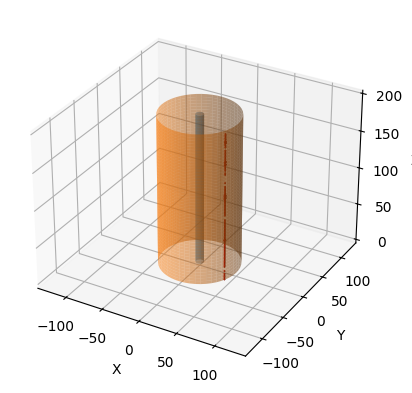

In [45]:
plot_state(Rs_sol[-1, :, :])

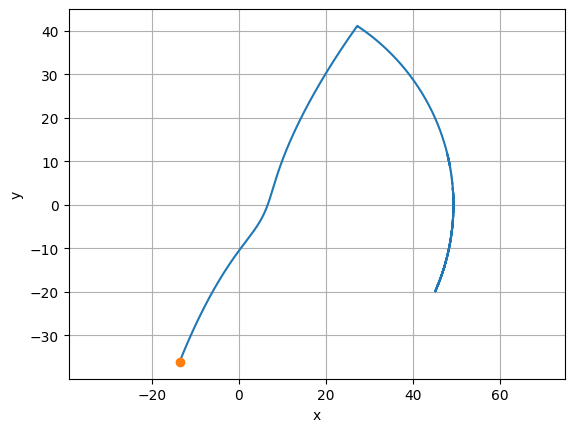

In [202]:
plot_trajectory(Rs_sol[:, 7, :])

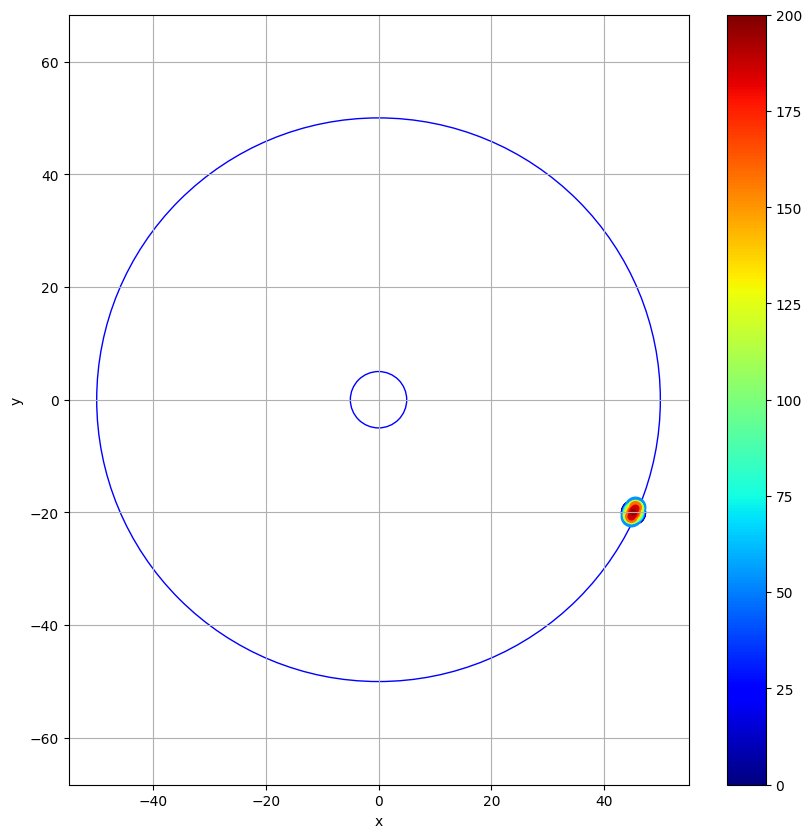

In [47]:
plot_2d(Rs_sol[-1,:,:])

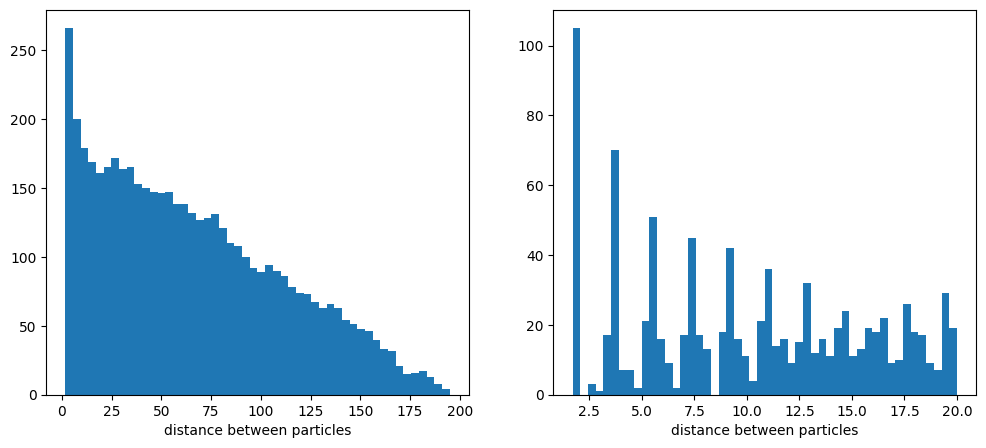

In [48]:
plot_dist(Rs_sol, 20 * R, 50)

No tumbling
omega/D_R: 30.660153746057613


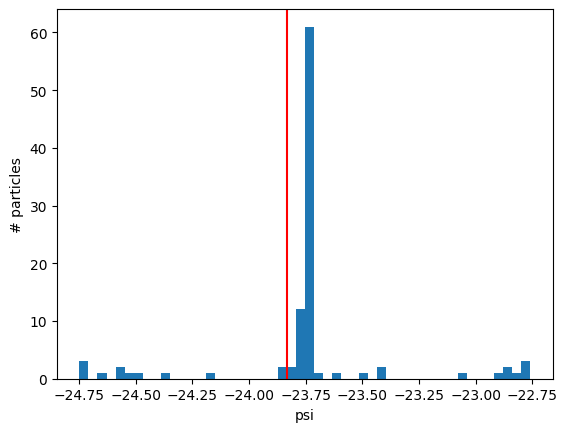

In [49]:
A, B, omega = get_params(0.1)
plot_angle(A, Rs_sol, 50)

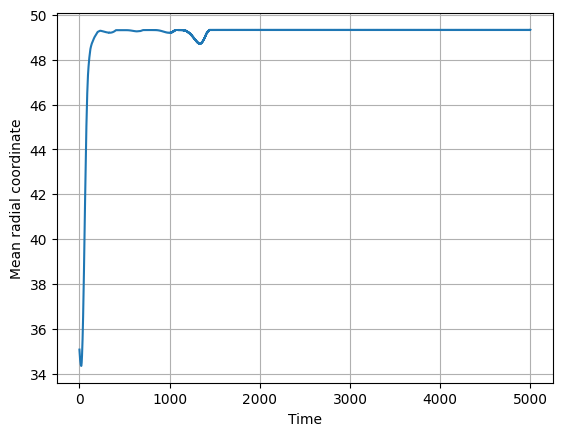

In [50]:
plot_R_mean(Rs_sol)

## With noise

In [189]:
ps_sol_noisy, Rs_sol_noisy, t_noisy = solver(0.1, 0.01, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)

No tumbling
omega/D_R: 30.660153746057613


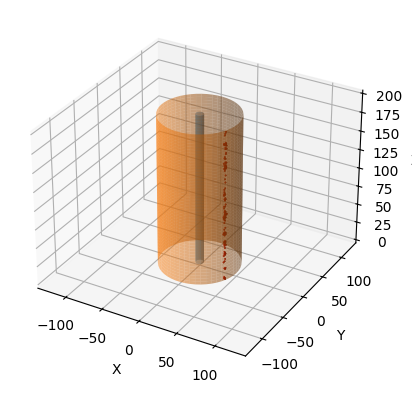

In [52]:
plot_state(Rs_sol_noisy[-1, :, :])

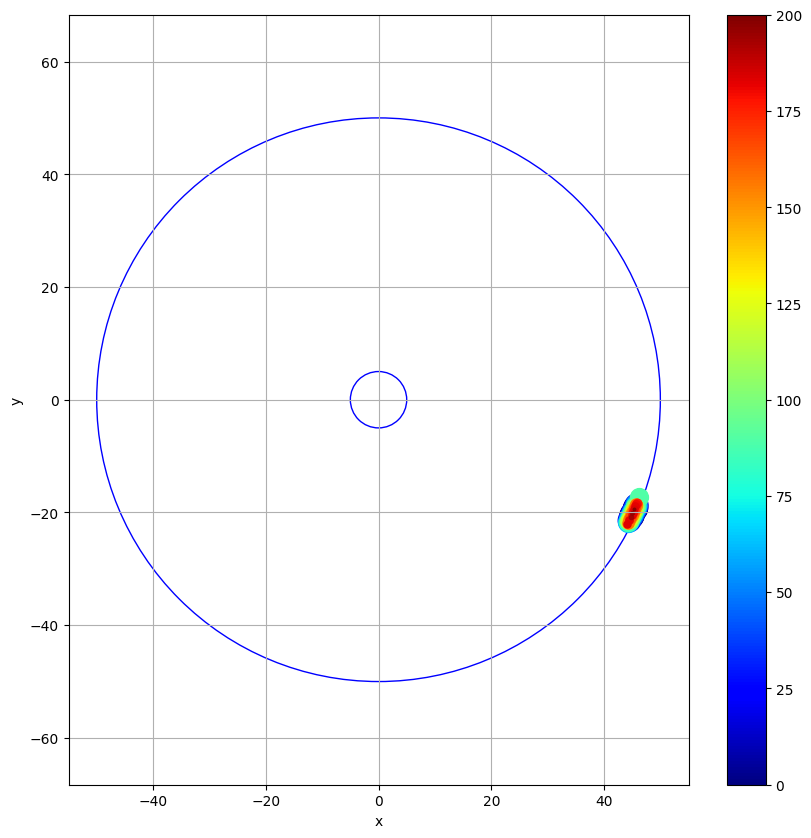

In [53]:
plot_2d(Rs_sol_noisy[-1,:,:])

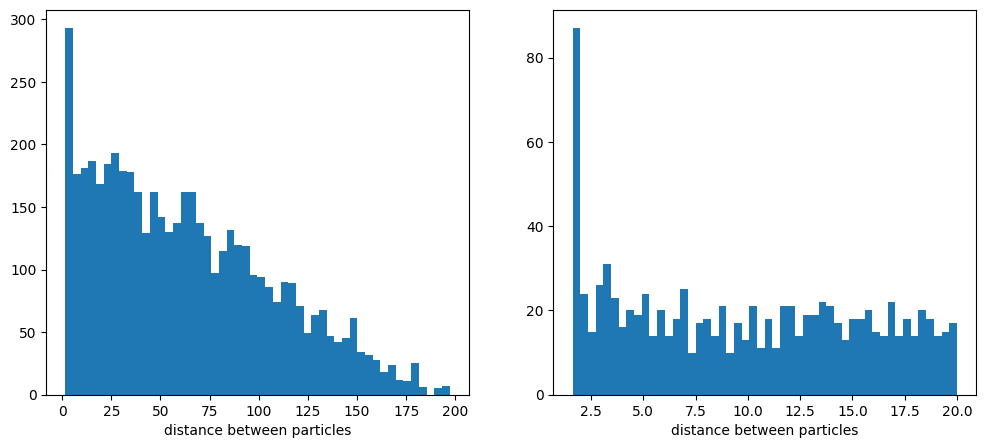

In [54]:
plot_dist(Rs_sol_noisy, 20 * R, 50)

No tumbling
omega/D_R: 30.660153746057613


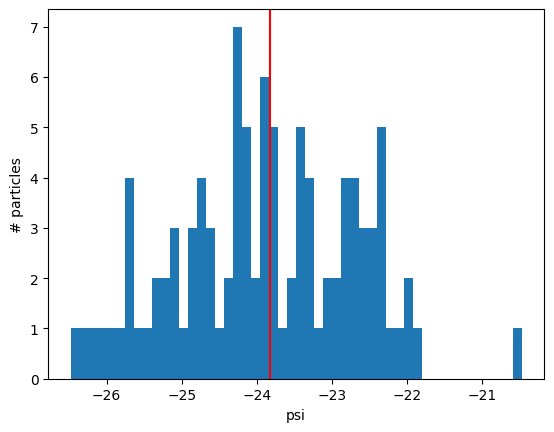

In [55]:
A, B, omega = get_params(0.1)
plot_angle(A, Rs_sol_noisy, 50)

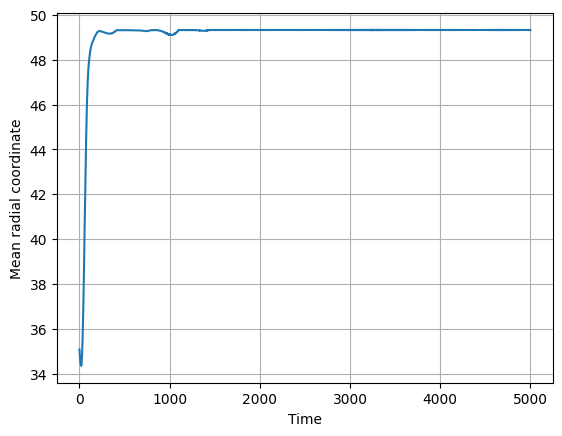

In [56]:
plot_R_mean(Rs_sol_noisy)

## Tumbling regime 

### Omega = 0.5

In [57]:
ps_sol_noisy_tumb, Rs_sol_noisy_tumb, t_noisy_tumb = solver(0.5, 0.01, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)

Tumbling period: 1431.7881813614306
omega/D_R: 153.30076873028807


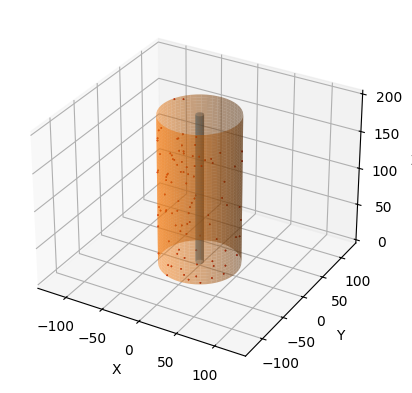

In [58]:
plot_state(Rs_sol_noisy_tumb[-1, :, :])

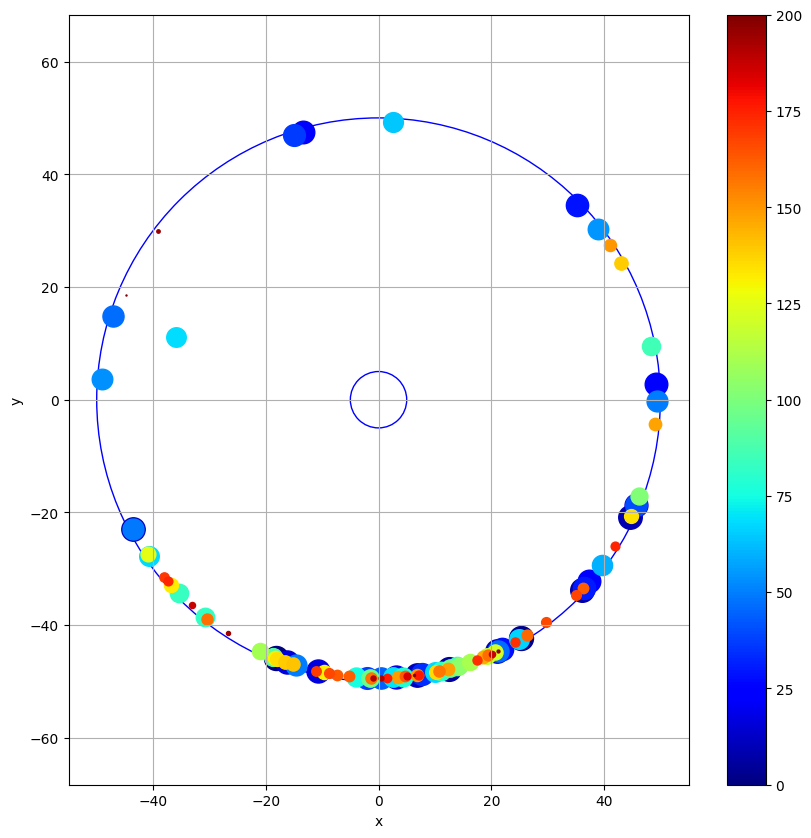

In [59]:
plot_2d(Rs_sol_noisy_tumb[-1, : ,:])

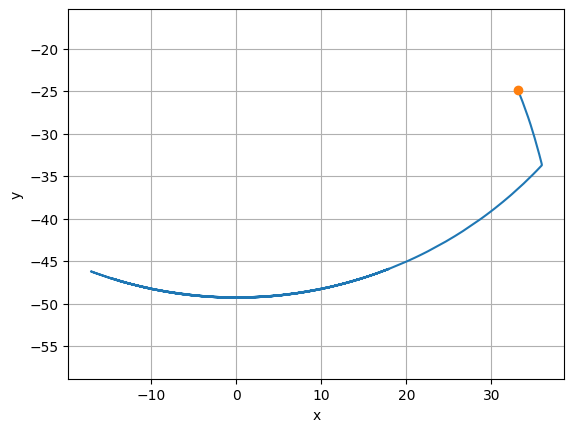

In [60]:
plot_trajectory(Rs_sol_noisy_tumb[:, 10, :])

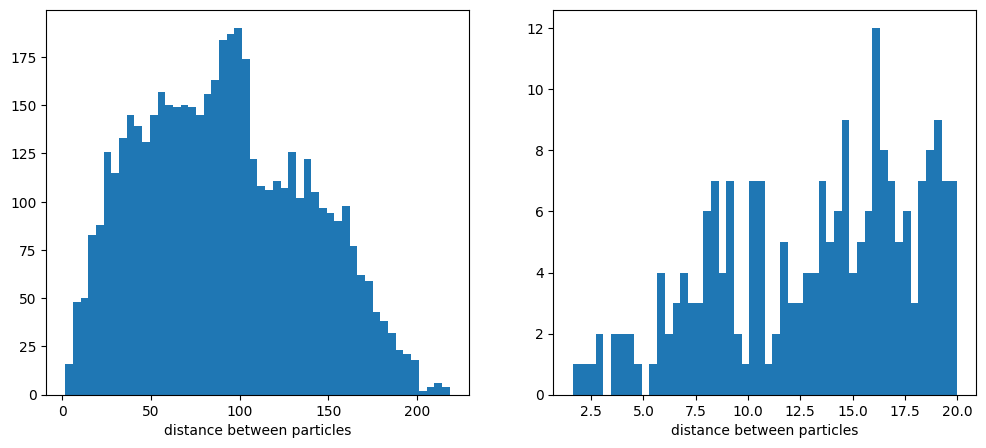

In [61]:
plot_dist(Rs_sol_noisy_tumb, 20 * R, 50)

Tumbling period: 1431.7881813614306
omega/D_R: 153.30076873028807


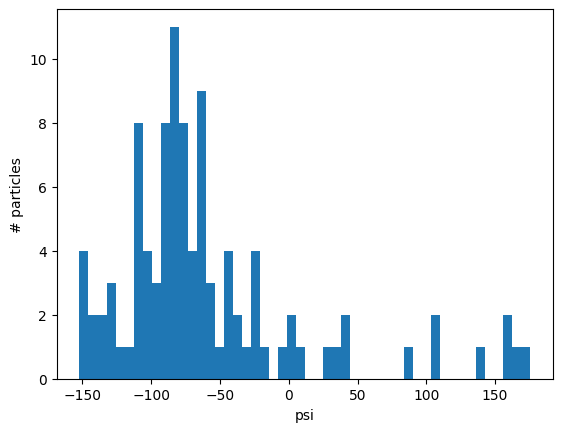

In [196]:
A, B, omega = get_params(0.5)
plot_angle(A, Rs_sol_noisy_tumb, 50)

In [194]:
def integrand(phi, A):
    return -1/(A - np.sin(phi)/2/beta)

In [210]:
np.mean(Rs_sol_noisy_tumb[-500:-1, :, 1], axis = 0)

array([-46.91781877, -48.75392598, -25.93703335, -49.28553919,
       -47.1536474 , -42.76055284, -49.28003746, -48.65044663,
        43.19922935, -49.16025668, -48.35451094, -42.5351096 ,
       -46.06181924,   6.47956502, -40.744113  , -48.95372941,
       -47.17757581, -42.89312848, -46.96054306, -42.82613529,
       -37.04057394, -45.8096282 , -47.51575371,  41.51991071,
       -42.5522519 , -48.17718051, -15.99024772, -47.52670793,
       -13.53833566, -48.33613708, -47.81885218, -47.85578756,
       -48.60430115, -26.3430487 , -46.80692941, -49.16616085,
       -44.88318649, -13.14687496, -38.25679861, -43.72197425,
       -48.97622555, -40.44483075, -49.23883273,  43.62617401,
       -48.6205841 , -46.7464904 , -39.533525  , -30.58995604,
       -13.20853459,   2.9345498 , -44.28820875,  10.59879056,
       -44.07899527,  -1.01548013, -30.24447419, -46.83978899,
       -30.16953798, -48.32829956, -49.22492041, -48.99189249,
       -43.21564417, -47.49281455,  23.1122887 ,  36.11

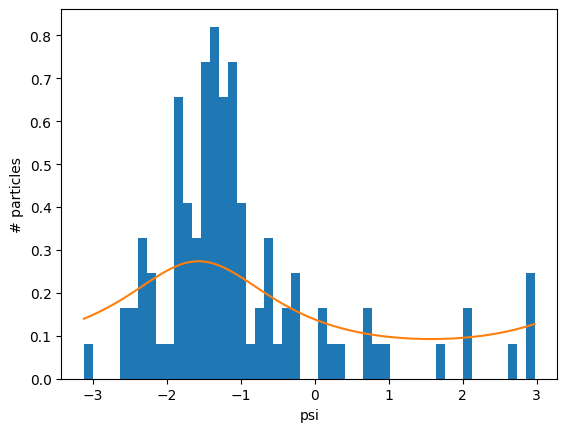

In [215]:
#psi = np.arctan2(Rs_sol_noisy_tumb[-1, :, 1], Rs_sol_noisy_tumb[-1, :, 0])
psi = np.arctan2(np.mean(Rs_sol_noisy_tumb[-500:-1, :, 1], axis = 0), np.mean(Rs_sol_noisy_tumb[-500:-1, :, 0], axis = 0))
if -1 < (2 * A * beta) and (2 * A * beta) < 1:
    phi_star = np.arcsin(2 * A * beta) 
    plt.axvline(phi_star, color = 'r')
#print(psi)
plt.hist(psi,  bins = 50, density=True)
psis = np.linspace(np.min(psi), np.max(psi), 100)
I, err = quad(integrand, -np.pi, np.pi, args = (A))
plt.plot(psis, integrand(psis, A) / I )
plt.xlabel(f'psi')
plt.ylabel(f'# particles')
plt.show()

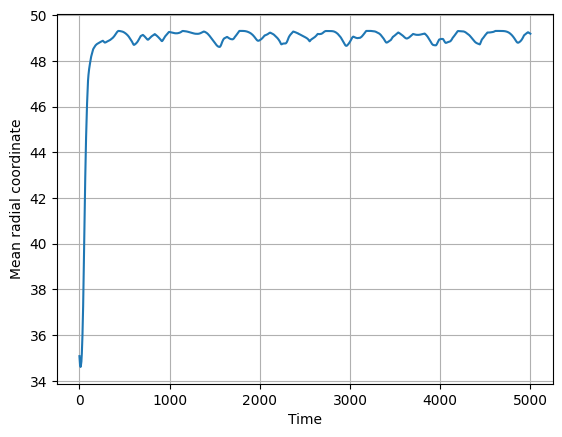

In [63]:
plot_R_mean(Rs_sol_noisy_tumb)

In [64]:
save_output(t_noisy_tumb, Rs_sol_noisy_tumb, ps_sol_noisy_tumb, 100, 0.5)

### Omega = 5

In [65]:
ps_sol_noisy_tumb_5, Rs_sol_noisy_tumb_5, t_noisy_tumb_5 = solver(5, 0.01, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


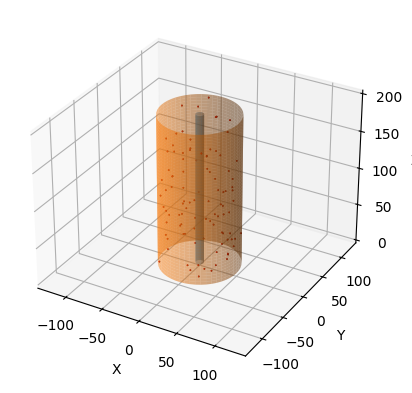

In [66]:
plot_state(Rs_sol_noisy_tumb_5[-1, :, :])

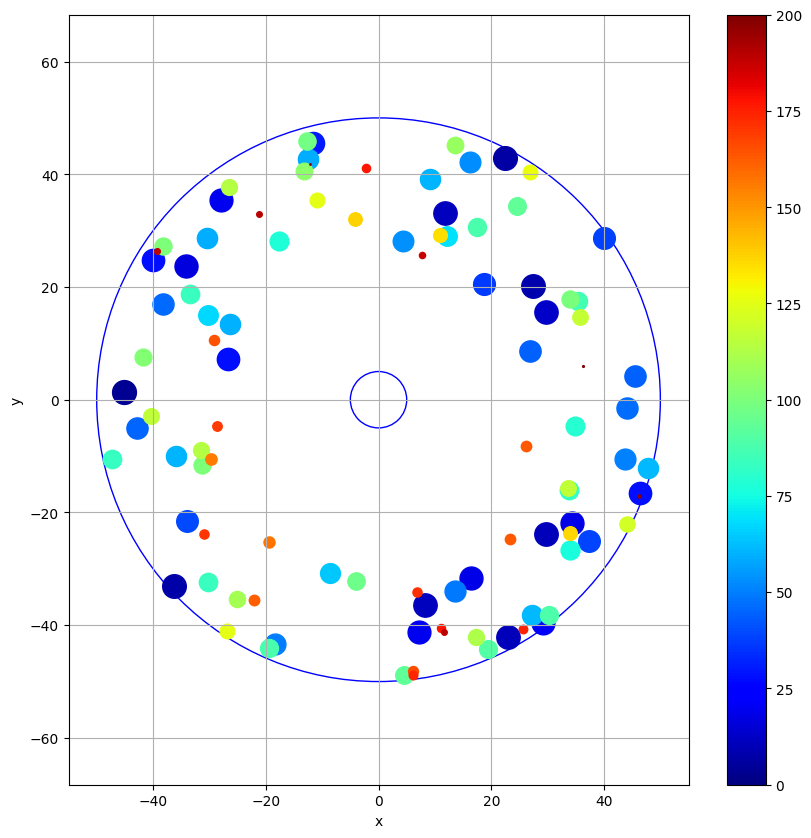

In [67]:
plot_2d(Rs_sol_noisy_tumb_5[-1,:,:])

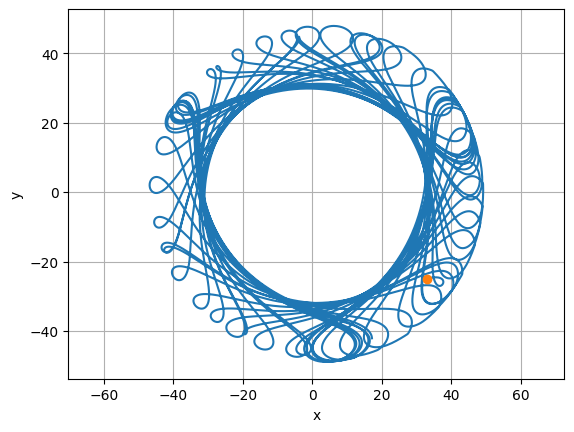

In [68]:
plot_trajectory(Rs_sol_noisy_tumb_5[:, 10, :])

In [69]:
TT = int(T_tumb*10)
n = 30
plot_trajectory(Rs_sol_noisy_tumb_5[:, 10, :][n * TT:(n + 2) * TT])

NameError: name 'T_tumb' is not defined

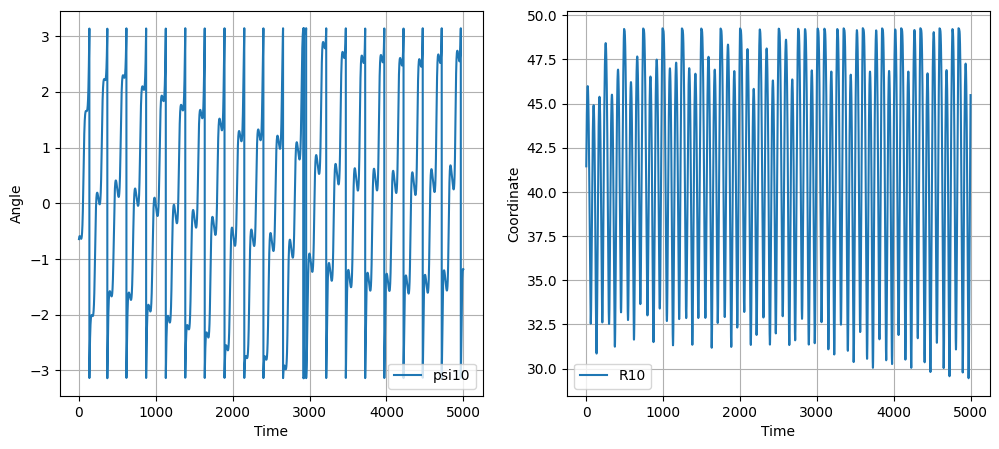

In [70]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))


i = 10
psi = np.arctan2(Rs_sol_noisy_tumb_5[:, i , 1], Rs_sol_noisy_tumb_5[:, i, 0])
phi = np.arctan2(ps_sol_noisy_tumb_5[:, i , 1], ps_sol_noisy_tumb_5[:, i, 0])
r = np.linalg.norm(Rs_sol_noisy_tumb_5[:, i, :2], axis=1)
    
axs[0].plot(t, psi, label=f'psi{i}')
#axs[0].plot(t, phi, label=f'phi{i}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Angle')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, r, label=f'R{i}')
    #axs[1].plot(t, Rs_sol[i][:,2], label=f'z{i}')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Coordinate')
axs[1].legend()
axs[1].grid(True)

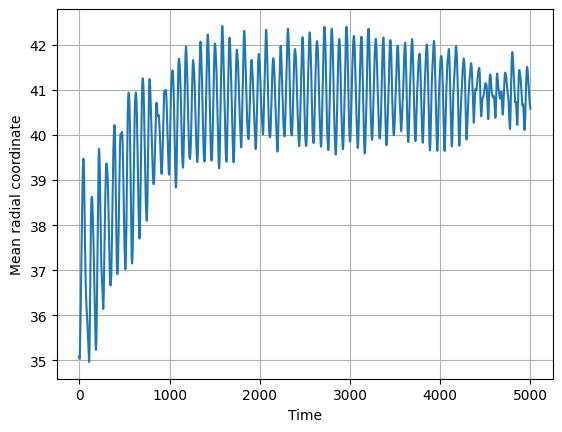

In [71]:
plot_R_mean(Rs_sol_noisy_tumb_5)

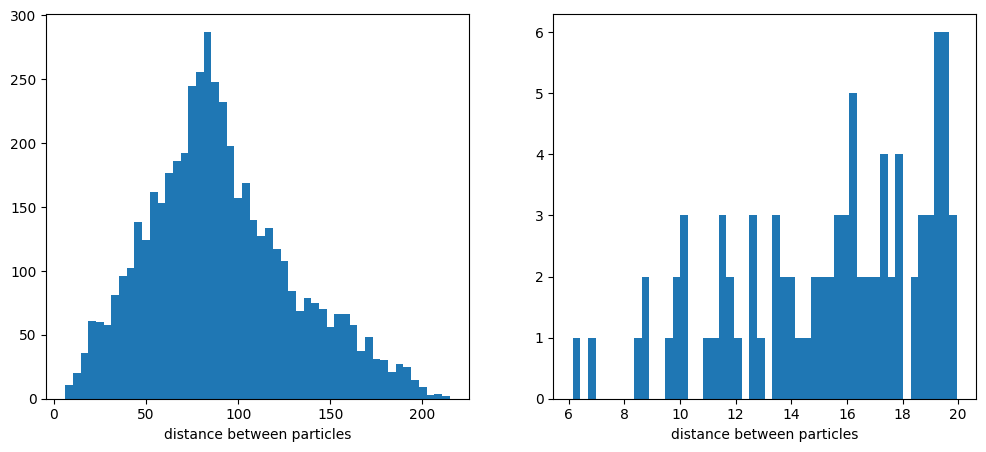

In [72]:
plot_dist(Rs_sol_noisy_tumb_5, 20 * R, 50)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


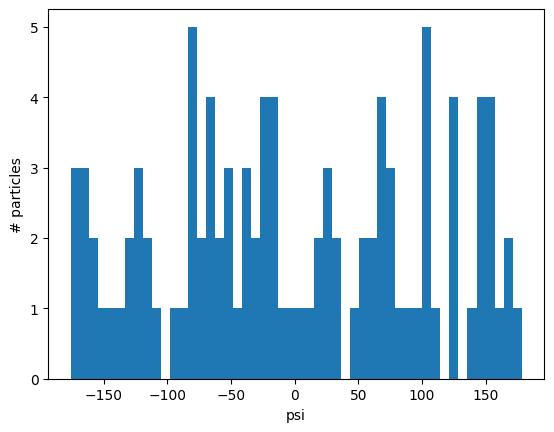

In [73]:
A, B, omega = get_params(5)
plot_angle(A, Rs_sol_noisy_tumb_5, 50)

In [74]:
save_output(t_noisy_tumb_5, Rs_sol_noisy_tumb_5, ps_sol_noisy_tumb_5, 100, 5)

## 300 particles

In [150]:
def simulation(Omega, N, epsilon, noise):
    zs = np.random.uniform(0, L, N)
    psis = np.random.uniform(0, 2*np.pi, N)
    Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
    vecs = np.random.normal(size = (N, 3))
    R0s = []
    p0s = []
    for i in range(N):
        R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
        p0s.append(vecs[i]/np.linalg.norm(vecs[i]))
    ps_sol, Rs_sol, t = solver(Omega, epsilon, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = noise)
    save_output(t, Rs_sol, ps_sol, N, Omega)
    return ps_sol, Rs_sol, t

In [76]:
simulation(5, 300, 0.1, noise=True)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [77]:
simulation(5, 500, 0.1, noise=True)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [78]:
simulation(0.25, 100, 0.1, noise = True)

Tumbling period: 17637.96660850271
omega/D_R: 76.65038436514403


In [79]:
simulation(0.5, 100, 1, noise = True)

Tumbling period: 1431.7881813614306
omega/D_R: 153.30076873028807


In [80]:
simulation(0.1, 100, 0.1, noise = True)

No tumbling
omega/D_R: 30.660153746057613


### Omega close to critical $\Omega_{crit} = 0.2475$

In [159]:
ps_024, RS_024, t_024 = simulation(0.24, 100, 0.1, noise = True)

No tumbling
omega/D_R: 73.58436899053827


No tumbling
omega/D_R: 73.58436899053827


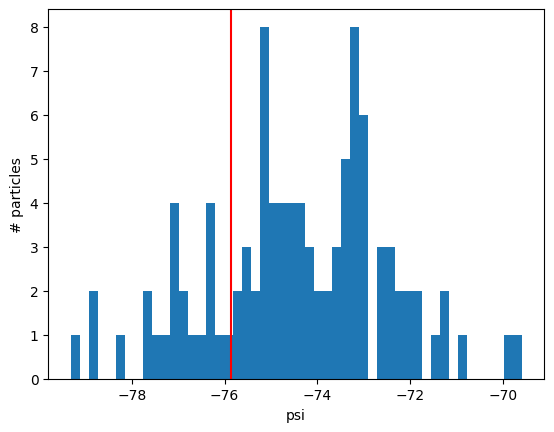

In [160]:
A, B, omega = get_params(0.24)
plot_angle(A, RS_024, 50)

In [164]:
ps_0246, RS_0246, t_0246 = simulation(0.246, 100, 0.1, noise = True)

No tumbling
omega/D_R: 75.42397821530172


No tumbling
omega/D_R: 75.42397821530172


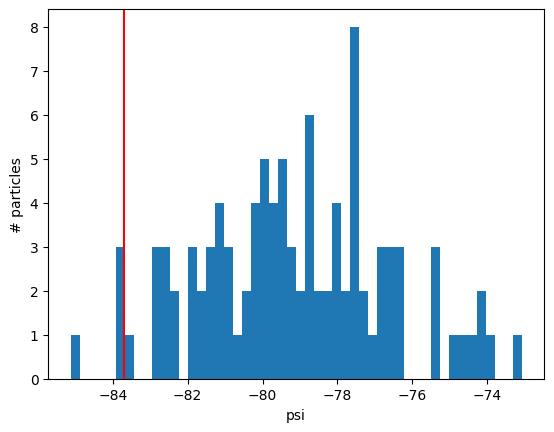

In [158]:
A, B, omega = get_params(0.246)
plot_angle(A, RS_0246, 50)

In [153]:
ps_0247, RS_0247, t_0247 = simulation(0.247, 100, 0.1, noise = True)

No tumbling
omega/D_R: 75.7305797527623


No tumbling
omega/D_R: 75.7305797527623


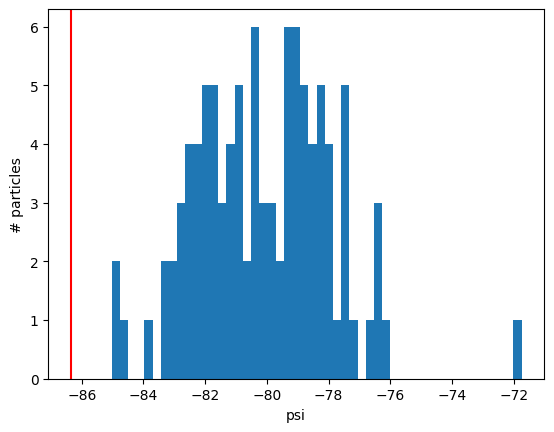

In [154]:
A, B, omega = get_params(0.247)
plot_angle(A, RS_0247, 50)

In [155]:
ps_02475, RS_02475, t_02475 = simulation(0.2475, 100, 0.1, noise = True)

No tumbling
omega/D_R: 75.88388052149259


No tumbling
omega/D_R: 75.88388052149259


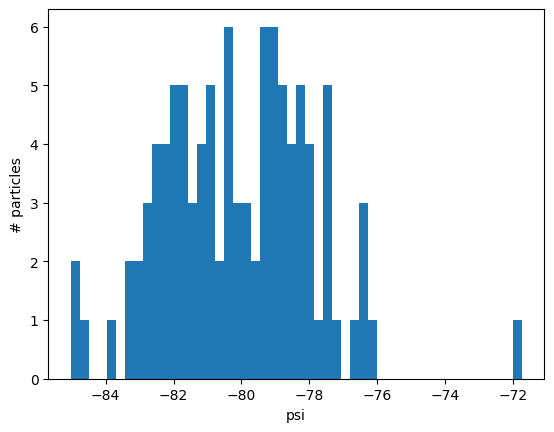

In [156]:
A, B, omega = get_params(0.2475)
plot_angle(A, RS_0247, 50)

In [151]:
ps_025, RS_025, t_025 = simulation(0.25, 100, 0.1, noise = True)

Tumbling period: 17637.96660850271
omega/D_R: 76.65038436514403


Tumbling period: 17637.96660850271
omega/D_R: 76.65038436514403


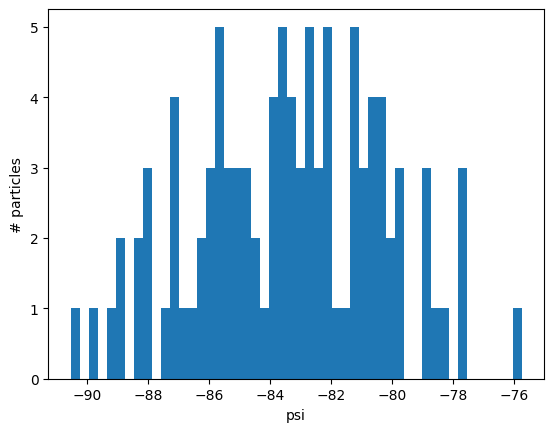

In [152]:
A, B, omega = get_params(0.25)
plot_angle(A, RS_025, 50)

non-interacting

In [165]:
simulation(0.2, 100, 0, noise = True);

No tumbling
omega/D_R: 61.32030749211523


In [166]:
simulation(10, 100, 0, noise = True);

Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


In [183]:
ps1, Rs1, t = simulation(1, 100, 0, noise = True);

Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


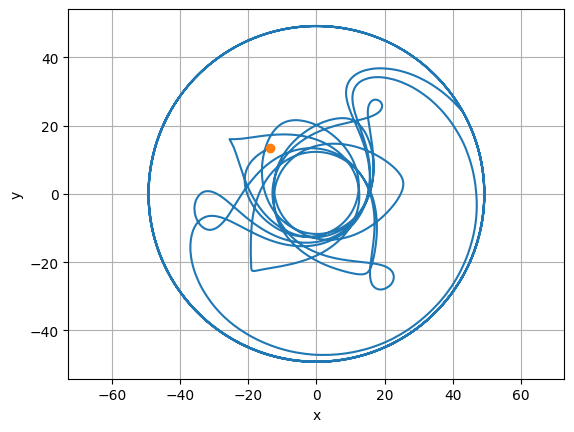

In [186]:
plot_trajectory(Rs1[:, 1, :])

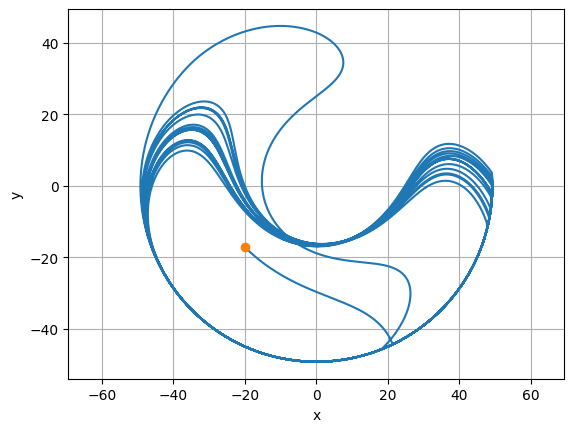

In [179]:
plot_trajectory(Rs2[:, 1, :])

In [170]:
ps5, Rs5, t = simulation(5, 100, 0.1, noise = True);

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


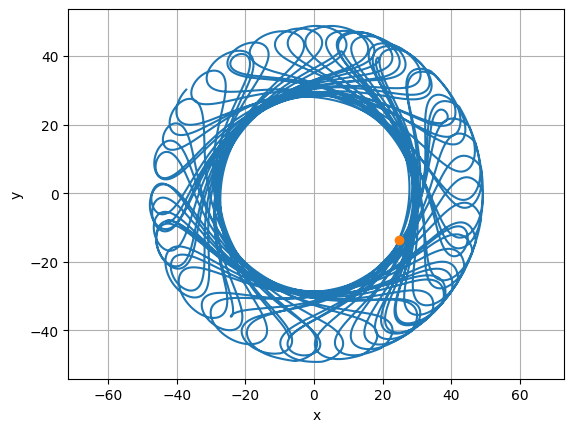

In [173]:
plot_trajectory(Rs5[:, 20, :])

In [182]:
k = np.zeros(3)
ps0, Rs0, t0 = simulation(0.1, 100, 0.1, noise = True);

No tumbling
omega/D_R: 30.660153746057613


TODO:
- [ ] doc for one particle
- [ ] Video
- [x] Cut-off at $3\sigma$
- [x] Neighbor lists scipy KDTree?
- [x] Particle distances for 100 hist
- [ ] Cluster finding
- [ ] smaller timestep
- [x] distance distribution over time
- [x] dynamic regime
- [x] projection at the end
- [ ] close to critical omega
- [ ] non interacting particles
- [ ] limit for high omega
  